# **AutoEncoders & Variational AutoEncoders**

<img src="https://pureai.com/articles/2020/05/07/~/media/ecg/pureai/images/2020/05/autoencoders3.asxh" width=70%>


## Chapter 1. AutoEncoders

The idea of AutoEncoder is really simple.<br>
We get data, pass it through encoder (stack of layers) to map it to lower dimension.<br>
Then from this lower dimension we reconstruct the passed data using MSE to compare them and measure quality.<br>
Sounds great, sounds good!<br>
AutoEncoder can be visualized as follows:<br>

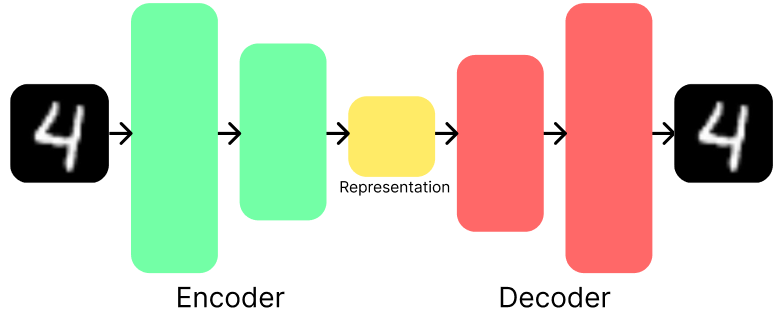

<br>

Finally, for image generation we pass random coordinates in this learned space and recreate image from coordinates.<br>
In training process AutoEncoder is learning how to organise data and how to decode from there.<br>
Let's implement autoencoder on MNIST dataset using both Linear layers and Convolutional layers!

In [226]:
import torch
from torch import nn
from torch import optim
from torch.nn import functional as F
from torch.utils.data import DataLoader
from torchvision.datasets import MNIST
from torchvision import transforms
import matplotlib.pyplot as plt

In [227]:
device = "cuda" if torch.cuda.is_available() else "cpu"
device

'cuda'

In [228]:
# Load the data

data = MNIST(root="./data", train=True, transform=transforms.ToTensor(), download=True)
data

Dataset MNIST
    Number of datapoints: 60000
    Root location: ./data
    Split: Train
    StandardTransform
Transform: ToTensor()

In [229]:
dataloader = DataLoader(data, batch_size=16, shuffle=True, pin_memory=True)
dataloader

### Let's start with a simple Feed-Forward nets

In [230]:
class Encoder(nn.Module):
  def __init__(self):
    super().__init__()
    self.encoder = nn.Sequential(
        nn.Linear(784, 512),
        nn.ReLU(),
        nn.Linear(512, 256),
        nn.ReLU(),
        nn.Linear(256, 128),
        nn.ReLU(),
        nn.Linear(128, 64),
        nn.ReLU(),
        nn.Linear(64, 32)
    )

  def forward(self, input):
    return self.encoder(input)

In [231]:
class Decoder(nn.Module):
  def __init__(self):
    super().__init__()
    self.decoder = nn.Sequential(
        nn.Linear(32, 64),
        nn.ReLU(),
        nn.Linear(64, 128),
        nn.ReLU(),
        nn.Linear(128, 256),
        nn.ReLU(),
        nn.Linear(256, 512),
        nn.ReLU(),
        nn.Linear(512, 784),
        nn.Sigmoid()
    )

  def forward(self, input):
    return self.decoder(input)

In [232]:
class AutoEncoder(nn.Module):
  def __init__(self, encoder, decoder):
    super().__init__()
    self.encoder = encoder
    self.decoder = decoder

  def forward(self, input):
    encoder_out = self.encoder(input)
    decoder_out = self.decoder(encoder_out)
    return decoder_out

In [233]:
# Training Loop!

epochs = 5

encoder = Encoder().to(device)
decoder = Decoder().to(device)
autoencoder = AutoEncoder(encoder, decoder).to(device)

lr = 0.001

loss_fn = nn.MSELoss()
optimizer = optim.RMSprop(autoencoder.parameters(), lr=lr)

Epoch: 1 | 148.7269287109375


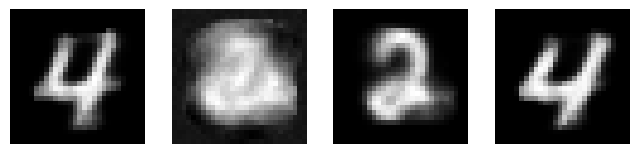

Epoch: 2 | 99.37059783935547


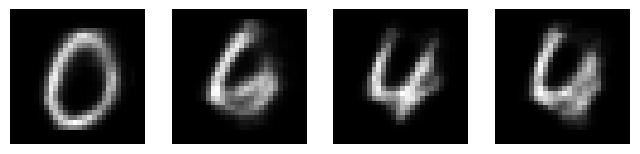

Epoch: 3 | 86.6413345336914


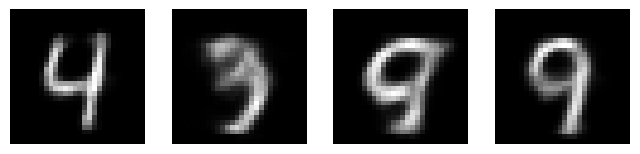

Epoch: 4 | 80.27216339111328


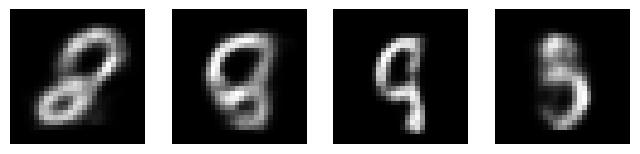

Epoch: 5 | 75.54869842529297


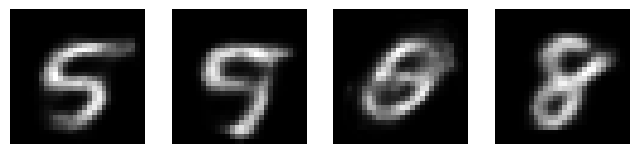

In [234]:
for epoch in range(epochs):
  autoencoder.train()
  epoch_loss = 0
  for img, _ in dataloader:
    img = img.to(device)
    img = img.view(-1, 1, 784)  # Flatten
    reconstruction = autoencoder(img)
    batch_loss = loss_fn(reconstruction, img)
    epoch_loss += batch_loss

    optimizer.zero_grad()
    batch_loss.backward()
    optimizer.step()

  print(f"Epoch: {epoch + 1} | {epoch_loss.item()}")

  # Generate Images from noise
  autoencoder.eval()
  with torch.inference_mode():
    random_ = torch.randn(4, 1, 32, device=device)
    reconstruction = decoder(random_).cpu().view(4, 28, 28, 1)
    plt.figure(figsize=(8, 4))
    for n, img in enumerate(reconstruction):
      plt.subplot(1, 4, n+1)
      plt.axis("off")
      plt.imshow(img, cmap="gray")
    plt.show()

Well...<br>
It's definitely something simmilar to MNIST digits, but it's really messy...<br>
Uhm... Maybe CNNs can Help!

In [240]:
class ConvEncoder(nn.Module):
  def __init__(self):
    super().__init__()
    self.encoder = nn.Sequential(
        nn.Conv2d(1, 64, kernel_size=4, stride=2),  # (B, 64, 13, 13)
        nn.ReLU(),
        nn.Conv2d(64, 128, kernel_size=3, stride=2),  # (B, 128, 6, 6)
        nn.ReLU(),
        nn.Conv2d(128, 256, kernel_size=3, stride=1),  # (B, 256, 4, 4)
        nn.ReLU(),
        nn.Flatten(),
        nn.Linear(256*4*4, 2048),
        nn.ReLU(),
        nn.Linear(2048, 1024),
        nn.ReLU(),
        nn.Linear(1024, 100)
    )

  def forward(self, input):
    return self.encoder(input)

In [241]:
class ConvDecoder(nn.Module):
  def __init__(self):
    super().__init__()
    self.decoder = nn.Sequential(
        nn.Linear(100, 1024),
        nn.ReLU(),
        nn.Linear(1024, 2048),
        nn.ReLU(),
        nn.Linear(2048, 4096),
        nn.Unflatten(1, (256, 4, 4)),
        nn.ReLU(),
        nn.ConvTranspose2d(256, 128, kernel_size=3, stride=1),  # (B, 128, 4, 4)
        nn.ReLU(),
        nn.ConvTranspose2d(128, 64, kernel_size=3, stride=2),  # (B, 64, 13, 13)
        nn.ReLU(),
        nn.ConvTranspose2d(64, 1, kernel_size=4, stride=2),  # (B, 1, 28, 28)
    )

  def forward(self, input):
    return self.decoder(input)

In [242]:
class ConvAutoEncoder(nn.Module):
  def __init__(self, encoder, decoder):
    super().__init__()
    self.encoder = encoder
    self.decoder = decoder

  def forward(self, input):
    enc_out = self.encoder(input)
    res = self.decoder(enc_out)
    return res

In [243]:
# Training Loop!

epochs = 5

conv_encoder = ConvEncoder().to(device)
conv_decoder = ConvDecoder().to(device)
conv_autoencoder = ConvAutoEncoder(conv_encoder, conv_decoder).to(device)

lr = 0.001

loss_fn = nn.MSELoss()
optimizer = optim.Adam(conv_autoencoder.parameters(), lr=lr)

Epoch: 0 | Loss: 121.00662781018764


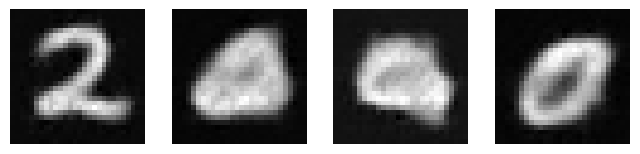

Epoch: 1 | Loss: 69.43843085784465


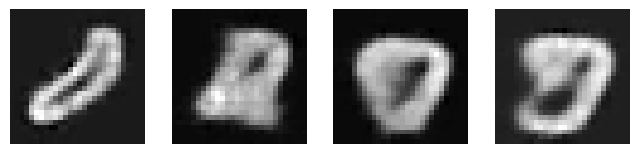

Epoch: 2 | Loss: 58.09872557595372


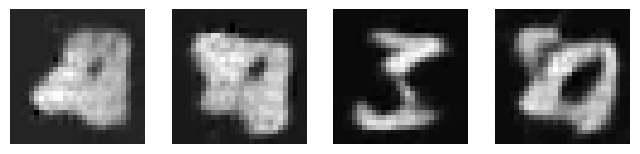

Epoch: 3 | Loss: 50.77647521905601


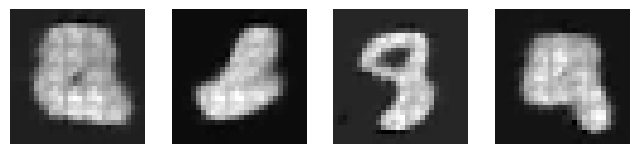

Epoch: 4 | Loss: 45.96412139059976


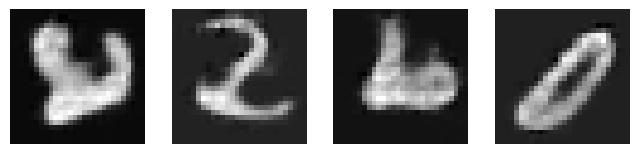

In [244]:
for epoch in range(epochs):
  conv_autoencoder.train()
  epoch_loss = 0
  for img_batch, _ in dataloader:
    img_batch = img_batch.to(device)
    reconstruction = conv_autoencoder(img_batch)
    batch_loss = loss_fn(reconstruction, img_batch)
    epoch_loss += batch_loss.item()
    optimizer.zero_grad()
    batch_loss.backward()
    optimizer.step()

  print(f"Epoch: {epoch} | Loss: {epoch_loss}")
  conv_autoencoder.eval()
  with torch.inference_mode():
    noise = torch.randn((4, 100)).to(device)
    reconstruction = conv_decoder(noise)  # (B, 1, 28, 28)
    plt.figure(figsize=(8, 4))
    for i, img in enumerate(reconstruction):
      plt.subplot(1, 4, i+1)
      plt.axis("off")
      plt.imshow(img.cpu().permute(1, 2, 0).detach().numpy(), cmap="gray")
    plt.show()

Oh... I might have came up with a bad CNN architecture...
Maybe, but let's see a deeper reason for this performance issue.<br>
Let's see how model handles Reconstruction of real images to make sure our CNN components are fine

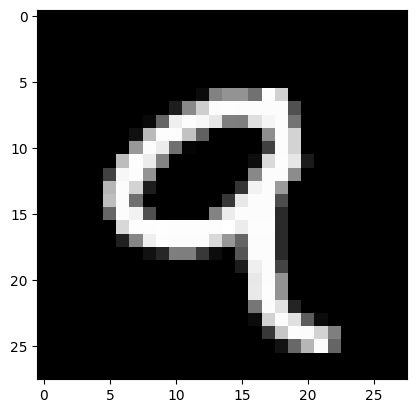

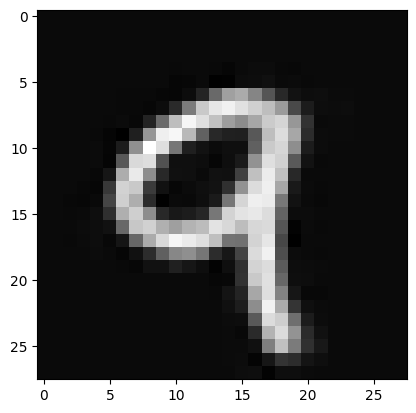

In [245]:
conv_autoencoder.eval()
with torch.inference_mode():
  for img_batch, _ in dataloader:
    img_batch = img_batch.to(device)
    img = img_batch[0].unsqueeze(0)  # (1, 1, 28, 28)
    reconstruction = conv_autoencoder(img).cpu()
    plt.imshow(img.squeeze(0).permute(1, 2, 0).cpu(), cmap="gray")
    plt.show()
    plt.imshow(reconstruction.squeeze(0).permute(1, 2, 0), cmap="gray")
    break

Hmm... Well it appears that our Decoder is more or less  fine.<br>

This means that there's a problem with our input we pass in.<br>
As I mentioned earlier AutoEncoder organizes samples in latent space, but this space is not structured enough, with many gaps.<br>
Selecting coordinate we can randomly land somewhere between 6 and 8 and our decoder will generate mix of 6 and 8 resulting in ugly results.<br>
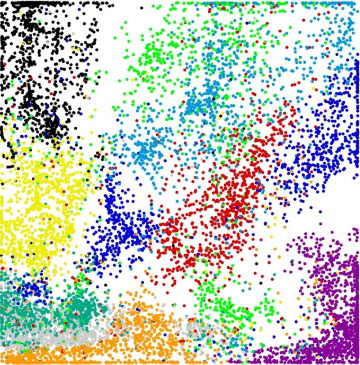


## Chapter 2. Variational AutoEncoders.
Variational AutoEncoders organize space in a better way.<br>
VAE represents latent space as a normal distribution learning mean and variance for it.<br>
This way, it stores only useful information and when sampling from it we'll fall only in meaningful spots.<br>
Point sampling now happens as:<br>
$z = \mu + \sigma \cdot \epsilon$, where $\epsilon$ - random noise vector.<br>
To keep distribution as close to normal as possible we use KL Divergence adding it to reconstruction loss (MSE).<br>

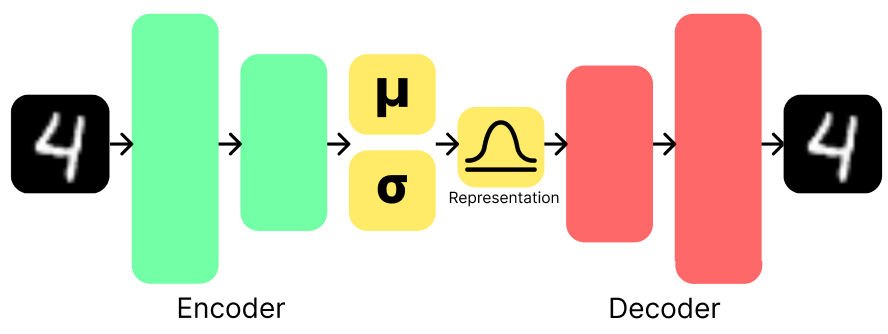

In [261]:
# TODO: Implement VAE